In [2]:
'''1. 데이터 준비
주가 데이터를 사용하기 위해 Yahoo Finance API를 활용해 데이터를 다운로드합니다. yfinance 라이브러리를 사용할 수 있습니다.'''

#python

#!pip install yfinance

'1. 데이터 준비\n주가 데이터를 사용하기 위해 Yahoo Finance API를 활용해 데이터를 다운로드합니다. yfinance 라이브러리를 사용할 수 있습니다.'

In [3]:
'''2. 데이터 전처리
주가 데이터를 가져와서 LSTM 모델에 맞게 전처리합니다. LSTM은 입력 데이터의 형태가 (batch_size, sequence_length, num_features) 여야 합니다.'''


'2. 데이터 전처리\n주가 데이터를 가져와서 LSTM 모델에 맞게 전처리합니다. LSTM은 입력 데이터의 형태가 (batch_size, sequence_length, num_features) 여야 합니다.'

In [4]:
#import sklearn

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn

In [6]:
# 데이터 다운로드
df = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
data = df['Close'].values

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

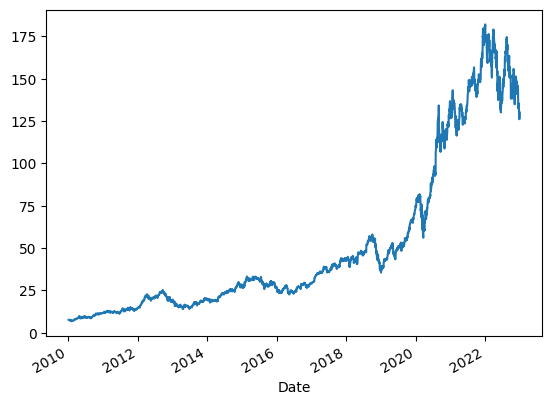

In [17]:
df['Close'].plot()

In [18]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1))

In [12]:
# 데이터셋 생성
def create_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [13]:
seq_length = 30
X, y = create_dataset(data, seq_length)

In [15]:
# 훈련과 테스트 데이터로 분할
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [69]:
# LSTM 입력에 맞게 reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 3. LSTM 모델 정의

In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTMModel, self).__init__() ## python 2,3 혼용 용도
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # ?nn.LSTM # return input_seq, hidden_state, cell_state
        self.fc = nn.Linear(hidden_size, 1)#fc는 Linear에 대한 초기화로 추정

    def forward(self, x):
        out, _ = self.lstm(x) # output, (hn, cn)
        out = self.fc(out[:, -1, :])  #? 하나만 선택한 이유가 무엇인가?
        return out        

# 4. 모델 학습

In [70]:
from time import time

In [35]:
stime_torch = time()
# 모델, 손실 함수, 최적화기 정의
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

# 학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print('pytorch 수행 속도...',time()-stime_torch)

Epoch [10/50], Loss: 0.0087
Epoch [20/50], Loss: 0.0077
Epoch [30/50], Loss: 0.0069
Epoch [40/50], Loss: 0.0055
Epoch [50/50], Loss: 0.0018
pytorch 수행 속도... 5.123888969421387


In [ ]:
# stime = time()
# import numpy as np
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from keras.optimizers import Adam

# # 데이터 예시 (여기서는 X_train과 y_train이 정의되어 있다고 가정)
# # X_train = ... (입력 데이터)
# # y_train = ... (타겟 데이터)

# # 모델 정의
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))  # 입력 형태 조정
# model.add(Dense(1))  # 출력층

# # 컴파일
# model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# # 학습
# num_epochs = 100
# model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=1)

In [ ]:
# 5. 예측 및 성능 평가
# 테스트 데이터로 예측

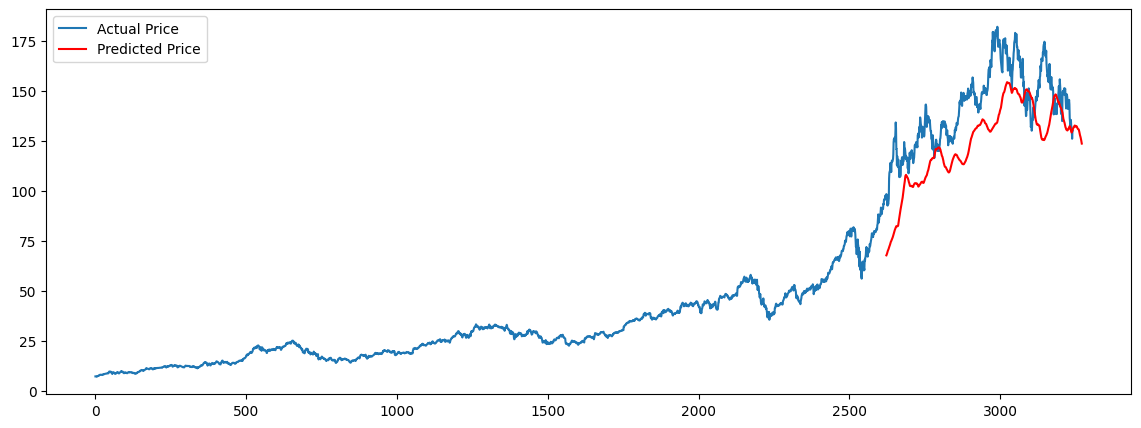

In [36]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = model(X_test_tensor)

# 결과를 원래 스케일로 되돌리기
y_test_pred = scaler.inverse_transform(y_test_tensor.numpy())

# 성능 평가
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(data[seq_length:]), label='Actual Price')
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(y_test_pred)), y_test_pred, label='Predicted Price', color='red')
plt.legend()
plt.show()

In [20]:
stime_torch = time()
# 모델, 손실 함수, 최적화기 정의
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)

# 학습
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print('pytorch 수행 속도...',time()-stime_torch)

Epoch [10/100], Loss: 0.0083
Epoch [20/100], Loss: 0.0048
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000
pytorch 수행 속도... 13.658244609832764


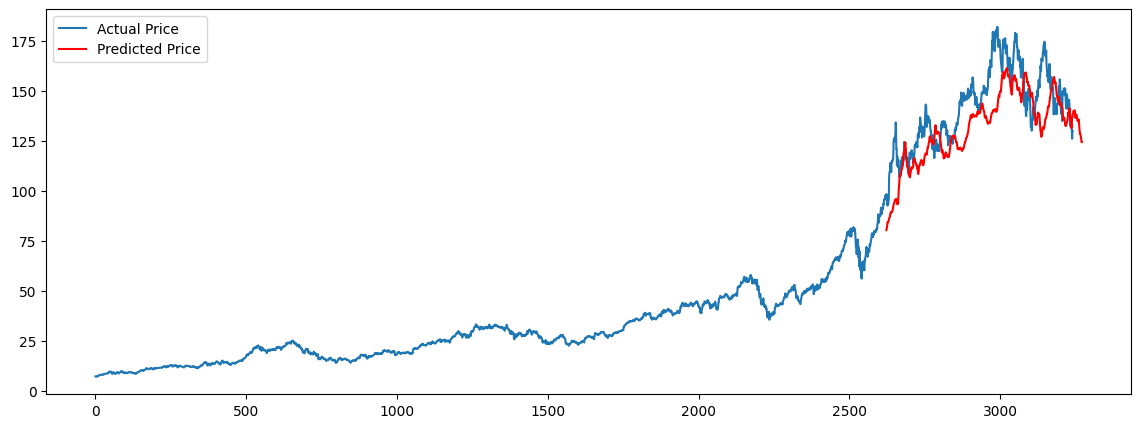

In [22]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = model(X_test_tensor)

# 결과를 원래 스케일로 되돌리기
y_test_pred = scaler.inverse_transform(y_test_tensor.numpy())

# 성능 평가
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(scaler.inverse_transform(data[seq_length:]), label='Actual Price')
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(y_test_pred)), y_test_pred, label='Predicted Price', color='red')
plt.legend()
plt.show()